In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from models import ann, regressionnet_resnet, mask_rcnn
from scripts import tools, dataset
from models.layers import *

tools.etc.set_GPU('0')
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Mask RCNN
class InferenceConfig(mask_rcnn.Config):
    NAME = "coco"
    NUM_CLASSES = 1 + 80
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
Human_Detector = mask_rcnn.MaskRCNN(mode="inference", config=config,model_dir='./snapshots/Mask_RCNN/')
Human_Detector.load_weights('./snapshots/Mask_RCNN/mask_rcnn_coco.h5', by_name=True)

In [3]:
All_Graph = tf.Graph()
with All_Graph.as_default():
    num_joints=14
    model_list=['Human_Joint_Pointer','Human_Pose_Estimator']
        
    with tf.variable_scope(model_list[0]):
        Human_Joint_Pointer = regressionnet_resnet.Regressionnet(data_shape=(128,128,3),num_joints=14,
                                                                 gpu_memory_fraction=None, phase='inference')  
    with tf.variable_scope(model_list[1]):
        Human_Pose_Estimator = ann.ann(input_shape=28,output_shape=10)
        
    var_name_list = [[] for _ in range(len(model_list))]
    var_dict_list = [dict() for _ in range(len(model_list))]
    
    for var in tf.global_variables():
        var_name_list[model_list.index(var.name.split('/')[0])].append(var)
        
    for i in range(len(model_list)):
        for var in var_name_list[i]:
            var_dict_list[i].update({'/'.join(var.name.split('/')[1:]).replace(':0',''):
                                     All_Graph.get_tensor_by_name(var.name)}) 

    saver_list = [tf.train.Saver(var_list=var_dict_list[i]) for i in range(len(model_list))]

In [4]:
config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph=All_Graph)

saver_path = ['./snapshots/Human_Joint_Pointer/Regressionnet_highest_pcp.ckpt',
              './snapshots/Human_Pose_Estimator/ann.ckpt']

for i in range(len(saver_path)):
    saver_list[i].restore(sess, saver_path[i])

INFO:tensorflow:Restoring parameters from ./snapshots/Human_Joint_Pointer/Regressionnet_highest_pcp.ckpt
INFO:tensorflow:Restoring parameters from ./snapshots/Human_Pose_Estimator/ann.ckpt


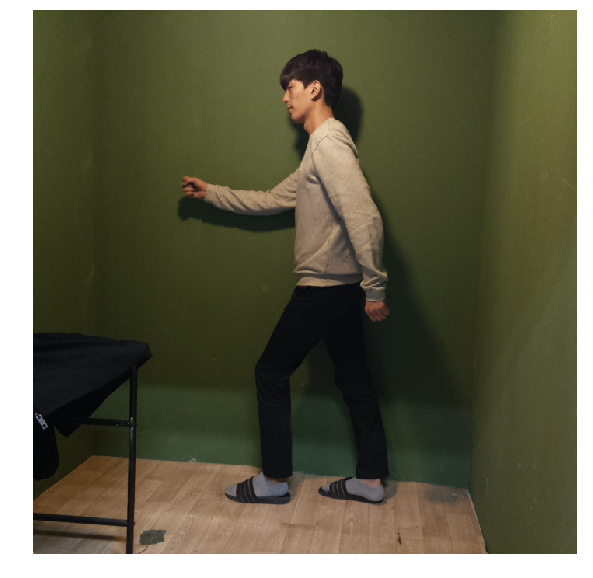

In [5]:
test_img=cv2.imread('/home/hahnz/image_1018/walking/181018 15:09:55.jpg')

plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.imshow(test_img[:,:,[2,1,0]])

In [6]:
Predicted = {}
Predicted['img'] = test_img.copy()

result = Human_Detector.detect([test_img], verbose=1)[0]
human_idx = list(result['class_ids']).index(mask_rcnn.class_names.index('person'))

###################
# Human Detection #
###################

# Bbox coor
x1,y1,x2,y2 = result['rois'][human_idx]
Predicted['bbox'] = result['rois'][human_idx].copy()

# Mask
mask = result['masks'][:,:,human_idx].reshape(-1)
mask = np.array([255 if detected else 0 for detected in mask]).reshape(test_img.shape[:2])
Predicted['mask'] = mask.copy()

# remove background
a,b = mask.shape
for i in range(a):
    for j in range(b):
        test_img[i,j] = test_img[i,j] if mask[i,j] else [0,0,0]
result = cv2.resize(test_img[x1:x2,y1:y2],(128,128))
sss = result.copy()

##########################################
# Human Joint Pointing & Pose Estimating #
##########################################

with All_Graph.as_default():
    # Joints
    result = tools.etc.normalize_img(result)
    result = sess.run(Human_Joint_Pointer.fc_regression,{Human_Joint_Pointer.x:[result],
                                                         Human_Joint_Pointer.is_train:False,
                                                         Human_Joint_Pointer.keep_prob:1.})
    Predicted['joints'] = result[0].squeeze().copy().reshape(-1,2)
    
    # Activities
    result = sess.run(Human_Pose_Estimator.hypothesis, {Human_Pose_Estimator.X:result, 
                                                        Human_Pose_Estimator.is_train:False,
                                                        Human_Pose_Estimator.keep_prob:1.})
    Predicted['Activity'] = result.squeeze().copy().argmax()
    

Processing 1 images
image                    shape: (700, 700, 3)         min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


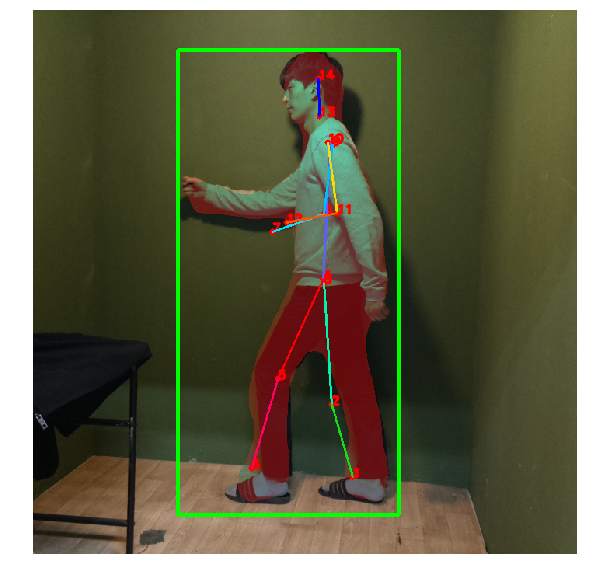

In [7]:
masked = Predicted['img'].copy()
a,b,_ = masked.shape
for i in range(a):
    for j in range(b):
        masked[i,j,2] = 100 if Predicted['mask'][i,j] else masked[i,j,2]
        
x1,y1,x2,y2 = Predicted['bbox'].copy()
pred_joints = Predicted['joints'].copy()
pred_joints[:,0] = (pred_joints[:,0]/128)*(y2-y1) + Predicted['bbox'][1]
pred_joints[:,1] = (pred_joints[:,1]/128)*(x2-x1) + Predicted['bbox'][0]

pred_canonical = tools.pose.convert2canonical(pred_joints[np.newaxis,:,:])[0]
masked = tools.etc.markJoints(masked,pred_joints)
masked = tools.etc.drawSticks(masked,pred_canonical['sticks'])
masked = cv2.rectangle(masked, (y1,x1), (y2,x2), (0,255,0), 3)
plt.axis('off')
plt.imshow(masked[:,:,[2,1,0]])